# Movie Reviews Recommender Systems: Web-Scraping, Predictions, User-Item Bias, RMSE, Content-Based & Collaborative Filtering
The goal of this project is to predict movie ratings with top critic ratings information web scraped from Rotten Tomatoes. The predictions will first look at only raw averages across all training dataset ratings. Then, predictions will be modified to account for bias by normalizing across users and across items. Content-based and collaborative filtering algorithms will be created and evaluated. Finally, Single Value Decomposition (SVD) methods will be applied to the previously created recommender systems. 

These goals are separated into two parts, as detailed below.

* **Part 1**: Rotten Tomatoes Web-Scraping, User-Item Matrix, Raw Mean, Bias, RMSE
* **Part 2**: Content-Based Filtering, Item-Item Collaborative Filtering
* **Part 3**: Single Value Decomposition Implementation.


## Set-Up

The following packages will be used for math, web scraping, machine learning, visualization, and other basic functions.

In [306]:
#Basic
import pandas as pd
import numpy as np
import re

#Math
import math
from fractions import Fraction

#Webscraping
import urllib.request
from bs4 import BeautifulSoup
import json
import requests

#Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#Content-based filtering
from rake_nltk import Rake
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## Part 1 Procedure
### Web-Scraping, User-Item Matrix, Raw Mean, Bias, RMSE

* Obtain and Clean Dataset: The dataset used will be web scraped from Rotten Tomatoes top critic reviews.

* Create User-Item Matrix: Movies that have been reviewed by at least half of the selected critics will be included in the predictions.

* Train Test Split: Split the remaining reviews between a train and test dataset, using a test size of 20% and stratifying by movie.

* Make Predictions: Make predictions for train and test reviews based on raw average and user-item bias.

* Evaluate Results: Determine the Root Mean Square Error of predictions to evaluate the accuracy of the model.

## Obtain and Clean Dataset
Rotten Tomatoes has a paginated list of movie reviews for every critic on their website. The following code chunk creates and executes a function `scrape_rotten_tomatoes` that accepts the following variables:
* `reviewer list`: a list of critics to include in the model
* `pages`: the number of pages of reviews to scrape 

For this dataset, nine top critics have been selected and the first five pages of their reviews have been scraped from Rotten Tomatoes. 

![reviews_table](https://raw.githubusercontent.com/mkivenson/Recommender-Systems/master/Global%20Baseline%20Predictors%20and%20RSME/Review_Table.png)

The function `scrape_rotten_tomatoes` includes the following steps:
* Create empty pandas dataframe to store scraped records in
* Use BeautifulSoup to web scrape json string of movie reviews for each critic and each page
* Extract relevant items from json string into a pandas dataframe
* Remove reviews with no ratings (some critics only evaluate a movie as rotten or fresh, with no numeric rating)
* Convert any letter ratings into a fractional rating (ex. A+ = 100/100)
* Convert fraction ratings to floats (most critics score movies out of 4, 5, or 10)
* Return the resulting dataframe without duplicate records (if over-pagination occurs)

In [2]:
def scrape_rotten_tomatoes(reviewer_list, pages):
    # Create empty pandas dataframe
    reviews = pd.DataFrame(columns = ['author','movie','rating','tomatometer','date','review'])
    
    # Use BeautifulSoup to web scrape json string of movie reviews for each reviewer page
    for x in reviewer_list:
        page_range = range(1,pages+1) # Pagination
        for i in page_range:
            URL = "https://www.rottentomatoes.com/critic/" + x + "/movies?page=" + str(i) 
            page = urllib.request.urlopen(URL)
            soup = BeautifulSoup(page)
            json_tag = soup.select('head script[type="application/ld+json"]')[0]
            json_string = json_tag.string
            json_string = json.loads(str(json_string))

            # Pull relevant items from json string into a pandas dataframe
            for thing in json_string['@graph'][1]['itemListElement']:
                reviews = reviews.append({
                    'author': thing['item']['author']['name'],
                    'movie': thing['item']['itemReviewed']['name'],
                    'rating': thing['item']['reviewRating']['ratingValue'],
                    'tomatometer': thing['item']['reviewRating']['tomatometer'],
                    'date': thing['item']['datePublished'],
                    'review': thing['item']['reviewBody']
                }, ignore_index = True)
                
    # Remove reviews with empty ratings
    reviews = reviews[pd.notnull(reviews.rating)]
    
    # Convert any letter grades to fraction grades (rare scenario)
    def letter_to_frac(x):
        x = x.replace(r'A+',"100/100")
        x = x.replace(r'A-',"90/100")
        x = x.replace(r'A',"95/100")
        x = x.replace(r'B+',"85/100")
        x = x.replace(r'B-',"75/100")
        x = x.replace(r'B',"80/100")
        x = x.replace(r'C+',"65/100")
        x = x.replace(r'C-',"55/100")
        x = x.replace(r'C',"60/100")
        x = x.replace(r'D+',"45/100")
        x = x.replace(r'D-',"35/100")
        x = x.replace(r'D',"40/100")
        x = x.replace(r'F',"20/100")
        return x
    reviews.loc[:, 'rating'] = letter_to_frac(reviews.rating)
    
    # Convert fraction grades to floats
    reviews["rating"] = reviews["rating"].apply(lambda x: float(float(x.split( '/' )[0]) / float(x.split( '/' )[1])))
    
    # Return the resulting clean dataframe without duplicates (caused if there is excessive pagination)
    return reviews.drop_duplicates()

# Define a list of reviewers using format "firstname-lastname"
reviewer_list = ["christy-lemire",
           "pete-hammond",
           "matthew-lickona",
           "rafer-guzman",
           "peter-howell",
           "richard-roeper",
           "ty-burr",
           "james-berardinelli",
           "katie-walsh"]

# Provide the amount of pages to iterate through
pages = 5

# Run the web-scraping and clean-up function and assign to the dataframe 'reviews'
reviews = scrape_rotten_tomatoes(reviewer_list, pages)
reviews.head()

,author,movie,rating,tomatometer,date,review
0,Christy Lemire,Holy Lands (Les terres saintes),0.375,rotten,"Jun 21, 2019",There's so little to these characters beyond a...
1,Christy Lemire,Wild Rose,0.875,fresh,"Jun 21, 2019","Wild Rose may sound like a familiar tune, but ..."
3,Christy Lemire,The Secret Life of Pets 2,0.500,rotten,"Jun 6, 2019","Your kids will be sufficiently entertained, bu..."
4,Christy Lemire,Rocketman,0.625,fresh,"May 28, 2019",Egerton gives a performance with such thrills ...
5,Christy Lemire,Running with Beto,0.750,fresh,"May 28, 2019","Running With Beto is an intimate, thorough loo..."


## Create User-Item Matrix
### Filter Results
To create a more condensed ratings model, only include movies that at least half of the selected critics have reviewed.

In [3]:
#Filter reviews to only show movies that at least half of reviewers have watched
movie_counts = reviews.groupby(by='movie').size()
movie_counts = pd.DataFrame(movie_counts).reset_index()
movie_counts.columns = ["movie","count_reviews"]
movie_list = list(movie_counts[movie_counts.count_reviews >= math.ceil(len(reviewer_list)/2)].movie)
print("There are " + str(len(movie_list)) + " movies that at least half of reviewers have watched.")

There are 128 movies that at least half of reviewers have watched.


### Matrix Creation
The following code chunk creates the user-item matrix for critic-movie ratings. Movies that have not been reviewed by a certain critic have values of "NaN" in the matrix.

In [4]:
#Take filtered reviews and transform into a user-item matrix
reviews_summary = reviews[reviews.movie.isin(movie_list)][["author","movie","rating"]]

reviews_matrix = reviews_summary.pivot_table(index = "movie", columns = "author", values = "rating")
reviews_matrix

author,Christy Lemire,James Berardinelli,Katie Walsh,Matthew Lickona,Pete Hammond,Peter Howell,Rafer Guzman,Richard Roeper,Ty Burr
movie,,,,,,,,,
A Private War,NaN,NaN,0.875,0.2,0.8,NaN,0.750,0.750,0.750
A Quiet Place,NaN,0.875,NaN,NaN,1.0,0.750,NaN,0.750,0.750
A Simple Favor,NaN,0.625,0.750,0.2,0.5,NaN,NaN,0.875,NaN
A Star Is Born,NaN,0.750,1.000,0.2,1.0,1.000,0.750,1.000,0.875
Aladdin,NaN,0.500,0.750,0.2,NaN,NaN,0.375,0.750,0.625
Alita: Battle Angel,NaN,0.625,0.500,NaN,0.6,0.500,0.625,0.375,NaN
American Made,NaN,NaN,NaN,0.4,0.9,0.750,0.750,NaN,0.750
Ant-Man and the Wasp,0.750,0.500,0.750,0.2,0.7,0.750,0.625,0.750,0.875
Aquaman,NaN,0.625,0.750,0.2,0.6,0.375,0.750,0.750,NaN


### Visualize Reviews
To preview potential bias in the recommender system, a rating overview by critic can be created. We see from the box plots below that Matthew Lickona is a particularly harsh critic. If a different list of critics is passed into the `scrape_rotten_tomatoes` function, the box plot will show different results.

Text(0.5, 1.0, 'Rating Overview by Reviewer')

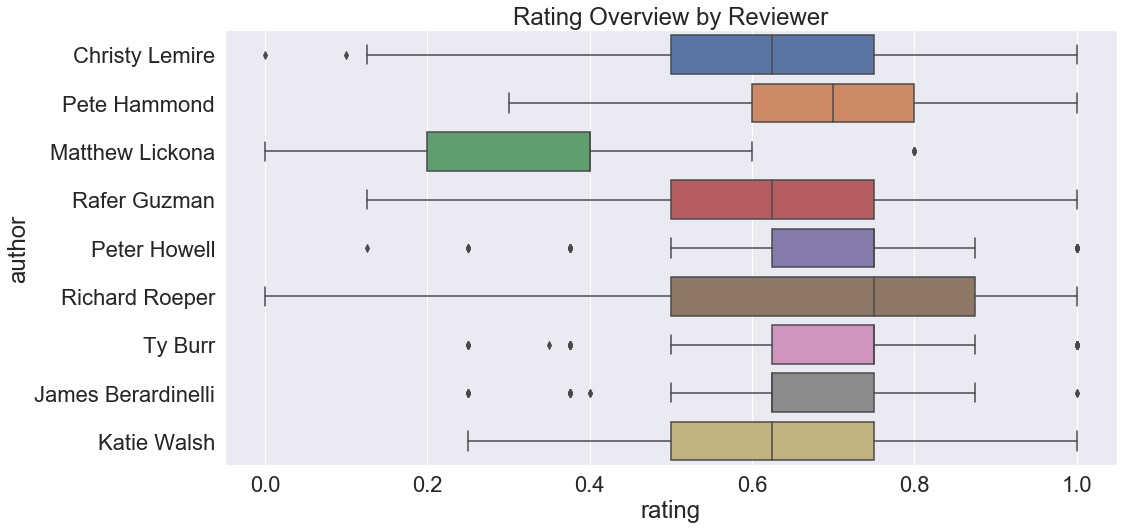

In [5]:
plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.boxplot(x = "rating", y = "author", data = reviews).set_title('Rating Overview by Reviewer')

## Train Test Split
To begin creating movie rating predictions for each critic, the reviews data is split between a test set and a train set. The test size will be 20% of the total reviews, and the split between train and test sets by stratifying by movie.

In [6]:
X = reviews_summary[["author","movie","rating"]]
y = reviews_summary["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify = X["movie"], 
                                                    random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(633, 3) (633,)
(159, 3) (159,)


## Make Predictions and Evaluate Results
### Raw Average Rating
The next step is to calculate the raw average (mean) rating for every critic-movie combination.

In [7]:
train_mean = round(y_train.mean(),2)
print("The mean rating for all reviewers/all movies in the train set is " + str(train_mean) + ".")

The mean rating for all reviewers/all movies in the train set is 0.64.


### Root Mean Square Error for Raw Average
The RMSE for using raw average as the predictor for both the training data and the test data is calculated below.

In [8]:
MSE_train = 0
for x in y_train:
    MSE_train = MSE_train + ((train_mean - x) ** 2)
RMSE_train = round(math.sqrt(MSE_train / len(y_train)),5)
print("The RMSE using the raw average as the predicted value for train data is " + str(RMSE_train) + ".")

MSE_test = 0
for x in y_test:
    MSE_test = MSE_test + ((train_mean - x) ** 2)
RMSE_test = round(math.sqrt(MSE_test / len(y_test)),5)
print("The RMSE using the raw average as the predicted value for test data is " + str(RMSE_test) + ".")

The RMSE using the raw average as the predicted value for train data is 0.22003.
The RMSE using the raw average as the predicted value for test data is 0.21355.


### Bias Calculations
To make the predictions more accurate, we take into account movie and critic bias. We saw from the visualization earlier that some critics are harsher than others. Similarly, some movies are of better quality than others. By taking critic harshness and movie quality into account, we can make these biases reflected in the predictions.

In [9]:
author_bias = X_train.groupby(by="author").agg("mean").reset_index()
author_bias = author_bias.assign(author_bias = lambda author_bias: author_bias.rating - train_mean)
movie_bias = X_train.groupby(by="movie").agg("mean").reset_index()
movie_bias = movie_bias.assign(movie_bias = lambda movie_bias: movie_bias.rating - train_mean)

In [10]:
#Add author_bias and movie_bias to the train set
X_train_bias = pd.merge(X_train, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_train_bias = pd.merge(X_train_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_train_bias = X_train_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the train set
X_train_bias = X_train_bias.assign(
    predictor = lambda X_train_bias: (train_mean + X_train_bias.author_bias + X_train_bias.movie_bias))
X_train_bias.predictor = X_train_bias.predictor.apply(lambda x: max(min(x,1),0))

#Add author_bias and movie_bias to the test set
X_test_bias = pd.merge(X_test, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_test_bias = pd.merge(X_test_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_test_bias = X_test_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the test set
X_test_bias = X_test_bias.assign(
    predictor = lambda X_test_bias: (train_mean + X_test_bias.author_bias + X_test_bias.movie_bias))
X_test_bias.predictor = X_test_bias.predictor.apply(lambda x: max(min(x,1),0))

### RMSE for Baseline Predictors
After taking bias into account in the baseline predictions, we see the RMSE calculations for both train and test data decrease.

In [11]:
MSE_train_bias = 0
for i in range(len(X_train_bias.predictor)):
    MSE_train_bias = MSE_train_bias + ((X_train_bias.rating[i] - X_train_bias.predictor[i]) ** 2)
RMSE_train_bias = round(math.sqrt(MSE_train_bias / len(X_train_bias)),5)
print("The RMSE using bias in the predicted value calculations for train data is " + str(RMSE_train_bias) + ".")

The RMSE using bias in the predicted value calculations for train data is 0.12435.


In [12]:
MSE_test_bias = 0
for i in range(len(X_test_bias.predictor)):
    MSE_test_bias = MSE_test_bias + ((X_test_bias.rating[i] - X_test_bias.predictor[i]) ** 2)
RMSE_test_bias = round(math.sqrt(MSE_test_bias / len(X_test_bias)),5)
print("The RMSE using bias in the predicted value calculations for test data is " + str(RMSE_test_bias) + ".")

The RMSE using bias in the predicted value calculations for test data is 0.15235.


## Summary
The prediction accuracy results are summarized below. It is evident that taking bias into account will improve prediction accuracy.

In [13]:
print("The RMSE for the raw mean predictor for the train set is " + str(RMSE_train))
print("The RMSE for the raw mean predictor for the test set is " + str(RMSE_test))
print("The RMSE for the raw mean with bias predictor for the train set is " + str(RMSE_train_bias))
print("The RMSE for the raw mean with bias predictor for the test set is " + str(RMSE_test_bias))

The RMSE for the raw mean predictor for the train set is 0.22003
The RMSE for the raw mean predictor for the test set is 0.21355
The RMSE for the raw mean with bias predictor for the train set is 0.12435
The RMSE for the raw mean with bias predictor for the test set is 0.15235


### Actual Ratings vs Predictions
It is also helpful to visualize a comparison of the predicted and actual ratings for the train and test sets. From the plots below, we see that the predicted and actual reviews are strongly correlated.

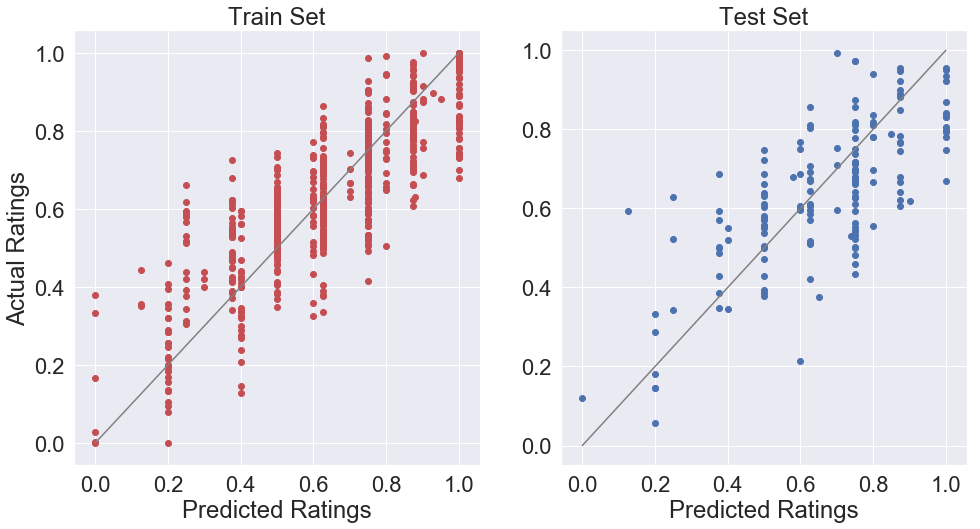

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["rating"], X_train_bias["predictor"], color='r')
x = np.arange(0,1.1,.1)
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Train Set')


plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["rating"], X_test_bias["predictor"], color='b')
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.show()

### Residuals
Looking at the residuals created by the difference between actual and predicted values is also an insightful visualization. For both the train and test sets, the residuals are symmetrically distributed and are mostly clustered around 0. 

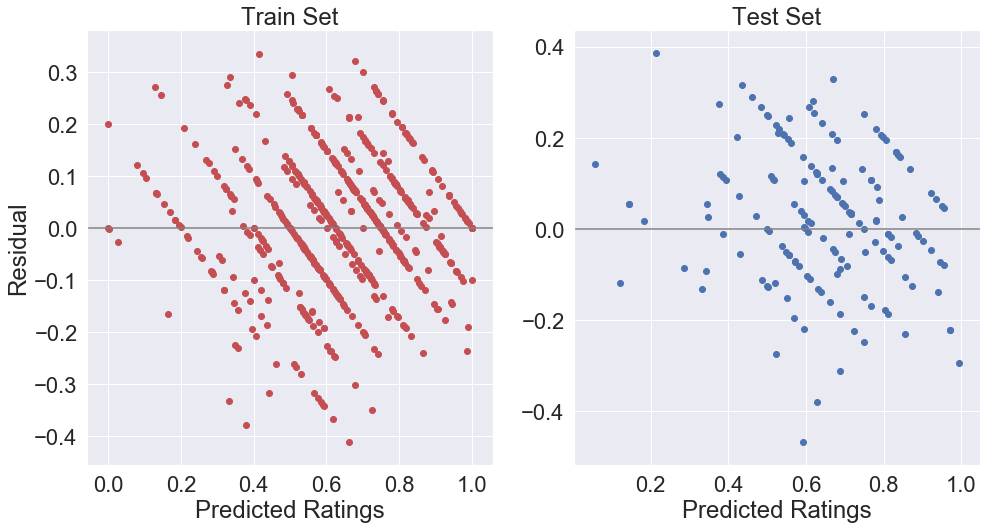

In [15]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["predictor"],X_train_bias["rating"] - X_train_bias["predictor"], color='r')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residual')
plt.axhline(y=0, color='gray')
plt.title('Train Set')

plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["predictor"],X_test_bias["rating"] - X_test_bias["predictor"], color='b')
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.axhline(y=0, color='gray')
plt.show()

## Part 2 Procedure

Part 2 of this project will use content-based filtering and item-item collaborative filting to create movie recommendations based on user input. An overview of the steps that will be taken is outlined below.

**Content Based Filtering**
* Create Movie Profiles
* Pre-Process Data
* Apply Count Vectorizer 
* Use and Evaluate Euclidian Distance Similarity Measure
* Use and Evaluate Cosine Similarity Measure
* Visualize Movie Recommendations

**Item-Item Collaborative Based Filtering**
* Visualize Distribution
* Normalize for User Bias
* Apply and Evaluate Cosine Similarity

## Content-Based Filtering
### Create Movie Profiles

The first step to a content-based filtering approach is to create movie profiles for each movie in our reviews dataset. To do this, the OMDB API is used and the following fields are extracted from the json response into a pandas dataframe:
* title
* rating
* genre
* director
* writer
* actors
* plot

A try-except approach is used in the for loop because the OMDB API has issues returning information for some movies, such as Ocean's 8 (since it stores the movie name as Ocean's Eight in its database). 

In [16]:
api_key = "1ac8ac3e"
movie_profile = pd.DataFrame(columns = ["title","rated","genre","director","writer","actors","plot"])
for movie in reviews["movie"].unique():
    URL = "http://www.omdbapi.com/" \
    + "?apikey=" + api_key \
    + "&t=" + movie
    response = requests.get(URL)
    try: 
        movie_profile = movie_profile.append({
            'title': response.json()['Title'],
            'rated': response.json()['Rated'],
            'genre': response.json()['Genre'],
            'director': response.json()['Director'],
            'writer': response.json()['Writer'],
            'actors': response.json()['Actors'],
            'plot': response.json()['Plot'],
    }, ignore_index = True)
    except:
        continue
movie_profile.head()

,title,rated,genre,director,writer,actors,plot
0,Wild Rose,R,"Drama, Music",Tom Harper,Nicole Taylor,"Jessie Buckley, Matt Costello, Jane Patterson,...",A musician from Glasgow dreams of becoming a N...
1,The Secret Life of Pets 2,PG,"Animation, Adventure, Comedy, Family","Chris Renaud, Jonathan del Val(co-director)",Brian Lynch,"Patton Oswalt, Kevin Hart, Harrison Ford, Eric...",Continuing the story of Max and his pet friend...
2,RocketMan,PG,"Comedy, Family, Sci-Fi",Stuart Gillard,"Oren Aviv (story), Craig Mazin (story), Greg E...","Harland Williams, Jessica Lundy, William Sadle...",Fred Z. Randall is a geeky spacecraft designer...
3,Running with Beto,TV-MA,Documentary,David Modigliani,N/A,"Beto O'Rourke, Amy O'Rourke, Cynthia Cano, Jod...",A behind-the-scenes documentary following Beto...
4,The Sun Is Also a Star,PG-13,"Drama, Romance",Ry Russo-Young,"Tracy Oliver (screenplay), Nicola Yoon (novel)","Yara Shahidi, Anais Lee, Charles Melton, John ...",A hopeless romantic ambivalent about his futur...


### Preprocessing
Once movie profiles for each film are created, the next step is to preprocess the profile information for each movie in order to apply text analysis techniques. To do this, Rake will be used to extract keywords from the movie plot. Then, regular expressions will be used to clean up director, writer and actor names. Each name will have lowercase, have spacing removed between first and last name, and then be added to a single column. Finally, punctuation and capital letters will be removed from the genre and rating code. All of these words will then be combined into a single string.

In [17]:
movie_words = movie_profile.copy()
#extract key words from the plot description
movie_words['key_words'] = ""
movie_words['people'] = ""
for index, row in movie_words.iterrows():
    plot = row['plot']
    r = Rake()
    r.extract_keywords_from_text(plot)
    key_words_dict_scores = r.get_word_degrees()
    row['key_words'] = ' '.join(list(key_words_dict_scores.keys()))

#combine director, writer, actor names and remove caps
for index, row in movie_words.iterrows():
    director = re.sub(r'\(.+\)|\s', '', row["director"])
    director = re.sub(r',', ' ', director).lower()
    writer = re.sub(r'\(.+\)|\s', '', row["writer"])
    writer = re.sub(r',', ' ', writer).lower()
    actors = re.sub(r'\(.+\)|\s', '', row["actors"])
    actors = re.sub(r',', ' ', actors).lower()
    row["people"] = "{} {} {}".format(director, writer, actors)                                 

#make genre lowercase, remove punctuation
for index, row in movie_words.iterrows():
    row['genre'] = re.sub(r'\-','',row['genre'])
    row['genre'] = re.sub(r',',' ',row['genre']).lower()

#make rating lowercase, remove punctuation
for index, row in movie_words.iterrows():
    row['rated'] = re.sub(r'\-','',row['rated']).lower()
    
movie_words["words"] =  "rated" + movie_words["rated"] + " " +\
                        movie_words["genre"] + " " +\
                        movie_words["people"] + " " +\
                        movie_words["key_words"]
movie_words[["title","words"]].head()

,title,words
0,Wild Rose,ratedr drama music tomharper nicoletaylor jes...
1,The Secret Life of Pets 2,ratedpg animation adventure comedy family c...
2,RocketMan,ratedpg comedy family scifi stuartgillard or...
3,Running with Beto,ratedtvma documentary davidmodigliani n/a beto...
4,The Sun Is Also a Star,ratedpg13 drama romance ryrusso-young tracyol...


### Count Vectorizer

To recommend movies, a Count Vectorizer algorithm will be used. The advantage of count vectorization over term frequency–inverse document frequency (td-idf) is that import fields such as movie ratings (PG, PG-13, R) that appear often will be considered equally despite being more frequent.

In [18]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

movie_matrix = count_vec.fit_transform(movie_words["words"])
#print(count_vec.get_feature_names())
print(movie_matrix.toarray())
print(movie_matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(817, 9017)


### Euclidean Distance

For a basic comparison on the similarity of movies, the euclidean distance can be measured. 

In [19]:
#euclidean distance
euclidean_matrix = euclidean_distances(movie_matrix, movie_matrix)
euclidean_matrix = pd.DataFrame(euclidean_matrix)
euclidean_matrix.columns = list(movie_words["title"])
euclidean_matrix.index = list(movie_words["title"])
euclidean_matrix

,Wild Rose,The Secret Life of Pets 2,RocketMan,Running with Beto,The Sun Is Also a Star,The Hustle,Wine Country,El Chicano,Hellboy,Dumbo,...,Yesterday,Body at Brighton Rock,Paddleton,Donnybrook,Tyrel,Anna and the Apocalypse,The Wind,Nekrotronic,Hot Summer Nights,Breaking In
Wild Rose,0.000000,6.244998,6.082763,6.480741,6.082763,5.916080,5.830952,5.744563,6.082763,6.244998,...,6.324555,5.744563,6.164414,5.744563,6.164414,7.549834,6.000000,6.782330,6.782330,5.385165
The Secret Life of Pets 2,6.244998,0.000000,6.480741,7.141428,6.928203,6.782330,6.708204,6.782330,6.928203,6.928203,...,7.141428,6.782330,7.000000,6.928203,7.000000,8.124038,6.855655,7.280110,7.681146,6.324555
RocketMan,6.082763,6.480741,0.000000,7.141428,6.928203,6.633250,6.557439,6.782330,6.633250,6.928203,...,7.141428,6.633250,6.855655,6.633250,6.855655,8.124038,6.708204,7.141428,7.549834,6.164414
Running with Beto,6.480741,7.141428,7.141428,0.000000,7.280110,7.141428,7.071068,7.141428,7.141428,7.416198,...,7.483315,7.000000,7.211103,7.141428,7.348469,8.544004,7.211103,7.745967,8.000000,6.708204
The Sun Is Also a Star,6.082763,6.928203,6.928203,7.280110,0.000000,6.782330,6.855655,6.782330,6.782330,6.782330,...,7.000000,6.782330,7.000000,6.782330,7.000000,8.366600,6.244998,7.549834,7.416198,6.000000
The Hustle,5.916080,6.782330,6.633250,7.141428,6.782330,0.000000,6.557439,6.782330,6.633250,7.071068,...,7.141428,6.633250,6.855655,6.633250,6.855655,8.124038,6.855655,7.280110,7.549834,6.164414
Wine Country,5.830952,6.708204,6.557439,7.071068,6.855655,6.557439,0.000000,6.557439,6.708204,7.000000,...,7.071068,6.403124,6.782330,6.557439,6.480741,7.937254,6.782330,7.211103,7.348469,6.244998
El Chicano,5.744563,6.782330,6.782330,7.141428,6.782330,6.782330,6.557439,0.000000,6.782330,6.928203,...,7.000000,6.480741,6.855655,6.480741,6.855655,8.124038,6.557439,7.416198,7.416198,6.164414
Hellboy,6.082763,6.928203,6.633250,7.141428,6.782330,6.633250,6.708204,6.782330,0.000000,7.071068,...,7.141428,6.633250,7.000000,6.782330,7.000000,8.000000,6.855655,7.141428,7.681146,6.000000
Dumbo,6.244998,6.928203,6.928203,7.416198,6.782330,7.071068,7.000000,6.928203,7.071068,0.000000,...,7.280110,6.782330,7.141428,6.928203,7.141428,8.366600,6.708204,7.681146,7.810250,6.324555


### Evaluate Euclidean Distance
We can now create a function to recommend movies based on a movie that the user has enjoyed. The inputs for this function `content_recommender` will be the movie and matrix to be used, as well as whether results should be sorted in ascending order or not. This is because for Euclidean Distance, movies with the lowest scores  are the most similar (so results must be sorted in ascending order). On the other hand, for Cosine Similarity, movies with the greatest scores are most similar (so results must be sorted in descending order). 

In [20]:
def content_recommender(movie, matrix, ascend):
    matrix = matrix.sort_values(movie,ascending=ascend)
    print("Recommended Movie | Value")
    for i in range(1,11): 
        print (matrix[movie].index.values[i] + " | " + str(round(matrix[movie][i],3)))
    print("\n")

Using the `content_recommender` function, we can test out the recommendations for a few movies. For this exercise, we used the following movies from different genres:
* Avengers: Endgame (superhero/action movie)
* The Secret Life of Pets 2 (animated children's movie)
* Us (Thriller/Horror movie)

In [21]:
#superhero movie
content_recommender("Avengers: Endgame", euclidean_matrix, True)

Recommended Movie | Value
Avengers: Infinity War | 4.796
Captain America: Civil War | 5.385
Being Frank | 5.568
The Green Fog | 5.745
Narcissister Organ Player | 5.831
Through Black Spruce | 6.0
Garry Winogrand: All Things are Photographable | 6.0
Obit | 6.083
The Valley | 6.083
The Scent of Rain | 6.164




In [22]:
#children's movie
content_recommender("The Secret Life of Pets 2", euclidean_matrix, True)

Recommended Movie | Value
Being Frank | 5.292
The Green Fog | 5.477
Narcissister Organ Player | 5.568
The Secret Life of Pets | 5.568
Garry Winogrand: All Things are Photographable | 5.745
Through Black Spruce | 5.745
The Valley | 5.831
The Star | 5.831
A Dog's Journey | 5.831
Mary Magdalene | 5.916




In [23]:
#horror/thriller movie
content_recommender("Us", euclidean_matrix, True)

Recommended Movie | Value
The Green Fog | 5.0
Being Frank | 5.0
Narcissister Organ Player | 5.292
Through Black Spruce | 5.477
Garry Winogrand: All Things are Photographable | 5.477
The Valley | 5.568
The Scent of Rain | 5.657
Mary Magdalene | 5.657
Looking Glass | 5.745
Roll Red Roll | 5.745




### Cosine Similarity

In addition to applying euclidean distance to the text describing each movie, it will also help to use cosine similarity in this content-based recommender system. First, the cosine_matrix of similarity measures between each movie is created.

In [24]:
#cosine similarity
cosine_matrix = cosine_similarity(movie_matrix, movie_matrix)
cosine_matrix = pd.DataFrame(cosine_matrix)
cosine_matrix.columns = list(movie_words["title"])
cosine_matrix.index = list(movie_words["title"])
cosine_matrix

,Wild Rose,The Secret Life of Pets 2,RocketMan,Running with Beto,The Sun Is Also a Star,The Hustle,Wine Country,El Chicano,Hellboy,Dumbo,...,Yesterday,Body at Brighton Rock,Paddleton,Donnybrook,Tyrel,Anna and the Apocalypse,The Wind,Nekrotronic,Hot Summer Nights,Breaking In
Wild Rose,1.000000,0.000000,0.000000,0.000000,0.053452,0.055728,0.056980,0.111456,0.000000,0.051434,...,0.050508,0.058321,0.052414,0.111456,0.052414,0.039841,0.054554,0.000000,0.089087,0.064820
The Secret Life of Pets 2,0.000000,1.000000,0.125109,0.037796,0.040000,0.041703,0.042640,0.041703,0.000000,0.076980,...,0.037796,0.000000,0.039223,0.000000,0.039223,0.059628,0.040825,0.070711,0.033333,0.048507
RocketMan,0.000000,0.125109,1.000000,0.000000,0.000000,0.043478,0.044455,0.000000,0.043478,0.040129,...,0.000000,0.000000,0.040893,0.043478,0.040893,0.031083,0.042563,0.073721,0.034752,0.050572
Running with Beto,0.000000,0.037796,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Sun Is Also a Star,0.053452,0.040000,0.000000,0.000000,1.000000,0.041703,0.000000,0.041703,0.041703,0.115470,...,0.075593,0.000000,0.039223,0.041703,0.039223,0.000000,0.204124,0.000000,0.100000,0.145521
The Hustle,0.055728,0.041703,0.043478,0.000000,0.041703,1.000000,0.044455,0.000000,0.043478,0.000000,...,0.000000,0.000000,0.040893,0.043478,0.040893,0.031083,0.000000,0.036860,0.034752,0.050572
Wine Country,0.056980,0.042640,0.044455,0.000000,0.000000,0.044455,1.000000,0.044455,0.000000,0.000000,...,0.000000,0.046524,0.041812,0.044455,0.125436,0.063564,0.000000,0.037689,0.071067,0.000000
El Chicano,0.111456,0.041703,0.000000,0.000000,0.041703,0.000000,0.044455,1.000000,0.000000,0.040129,...,0.039406,0.045502,0.040893,0.086957,0.040893,0.031083,0.085126,0.000000,0.069505,0.050572
Hellboy,0.000000,0.000000,0.043478,0.000000,0.041703,0.043478,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062167,0.000000,0.073721,0.000000,0.101144
Dumbo,0.051434,0.076980,0.040129,0.000000,0.115470,0.000000,0.000000,0.040129,0.000000,1.000000,...,0.036370,0.041996,0.037743,0.040129,0.037743,0.028689,0.117851,0.000000,0.032075,0.093352


### Evaluate Cosine Similarity
Using the same `content_recommender` function above, a list of 10 most-recommended movies can be produced for a selected movie. Let's try this on the same movies used in the previous section and compare outcomes. 

In [25]:
content_recommender("Avengers: Endgame", cosine_matrix, False)

Recommended Movie | Value
Avengers: Infinity War | 0.567
Captain America: Civil War | 0.412
Men in Black: International | 0.246
Captain Marvel | 0.222
Wonder Woman | 0.2
Aquaman | 0.182
Jurassic World: Fallen Kingdom | 0.179
Star Wars: The Last Jedi | 0.175
Justice League | 0.173
Solo: A Star Wars Story | 0.173




In [26]:
content_recommender("The Secret Life of Pets 2", cosine_matrix, False)

Recommended Movie | Value
The Secret Life of Pets | 0.392
The Star | 0.262
The Nut Job 2: Nutty by Nature | 0.244
Ralph Breaks the Internet | 0.244
Wonder Park | 0.24
A Dog's Journey | 0.229
Kung Fu Panda 3 | 0.223
Christopher Robin | 0.219
UglyDolls | 0.219
How to Train Your Dragon: The Hidden World | 0.212




In [27]:
content_recommender("Us", cosine_matrix, False)

Recommended Movie | Value
Hereditary | 0.251
Lizzie | 0.227
The Little Stranger | 0.191
Escape Room | 0.178
Unfriended: Dark Web | 0.178
Unsane | 0.174
Flatliners | 0.174
Overlord | 0.174
Berlin Syndrome | 0.171
Annihilation | 0.171




### Visualize Movie Recommendations
To see recommendations at a larger scale, the following heatmap of movie cosine similarites is created. The script selects 15 movies randomly from the entire movies dataframe to avoid overcrowding the chart. Each movie has a cosine similarity of 1 with itself, and much lower similarities with other movies. A cosine similarity of 0.15 or above between movies indicates that those movies are likely to be highly recommended.

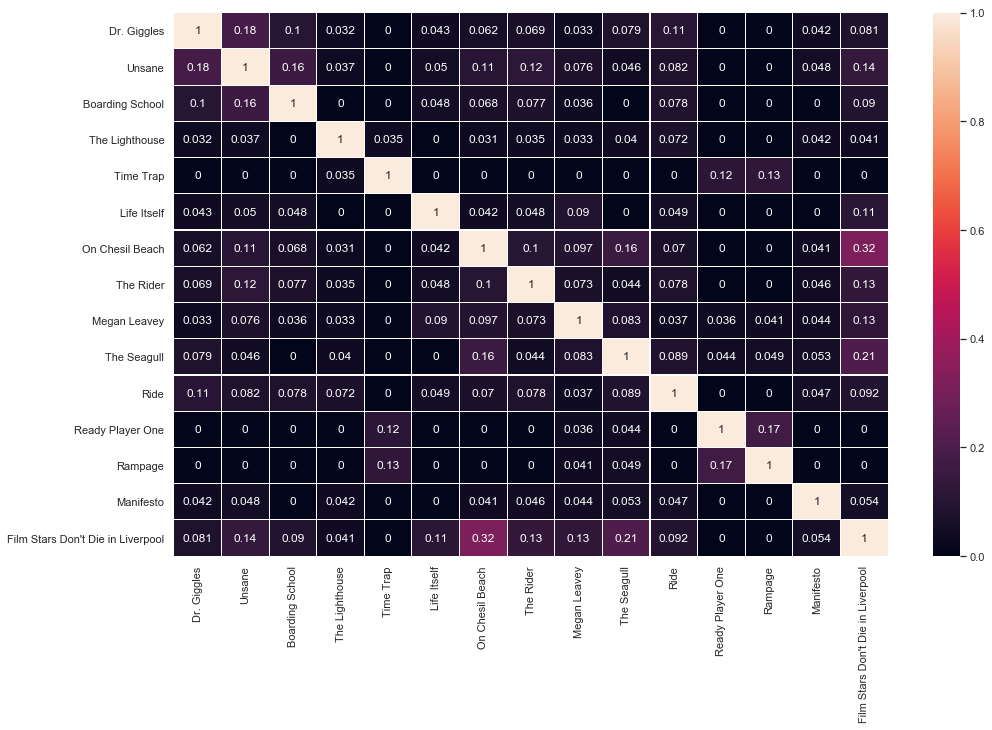

In [207]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.set(font_scale = 1)
x = random.sample(range(0, len(cosine_matrix) + 1), 15)
sns.heatmap(cosine_matrix.iloc[x,x], linewidths=.1, annot=True)

## Item-Item Collaborative Filtering
### Rating Distribution
We can begin by visualizing the distribution of movie reviews. This shows where most of the reviews are centered and it seems like the distribution of reviews is nearly-normal. 

(0, 1)

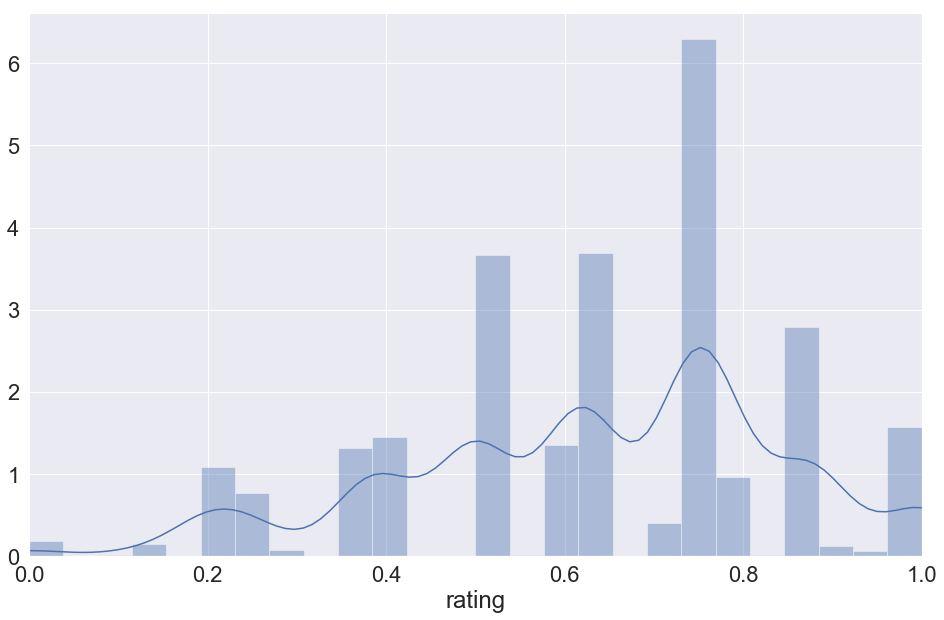

In [29]:
### Visualization
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.distplot(reviews["rating"]).set_xlim(0,1)

### Normalize for User Bias
The next step is to create a user-item matrix normalized for critic bias. To do this, we subtract each critic's mean rating from their individual movie ratings. 

In [30]:
reviews_matrix_transpose = reviews_matrix.transpose()
critic_means = reviews_matrix_transpose.mean(axis=1)
reviews_matrix_transpose = (reviews_matrix_transpose - critic_means[:,None]).fillna(0)
reviews_matrix_transpose

movie,A Private War,A Quiet Place,A Simple Favor,A Star Is Born,Aladdin,Alita: Battle Angel,American Made,Ant-Man and the Wasp,Aquaman,Avengers: Endgame,...,Tolkien,Tomb Raider,Toy Story 4,Tully,Unsane,Us,Venom,Vice,Vox Lux,Widows
author,,,,,,,,,,,,,,,,,,,,,
Christy Lemire,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101226,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.226226,0.000000,0.000000,-0.148774,0.000000,0.000000,0.000000
James Berardinelli,0.000000,0.213095,-0.036905,0.088095,-0.161905,-0.036905,0.000000,-0.161905,-0.036905,0.088095,...,-0.036905,0.000000,0.088095,-0.036905,0.088095,-0.036905,-0.161905,-0.036905,0.088095,0.213095
Katie Walsh,0.182941,0.000000,0.057941,0.307941,0.057941,-0.192059,0.000000,0.057941,0.057941,0.000000,...,0.000000,0.000000,0.307941,0.307941,0.000000,0.182941,-0.067059,0.057941,-0.192059,0.182941
Matthew Lickona,-0.082857,0.000000,-0.082857,-0.082857,-0.082857,0.000000,0.117143,-0.082857,-0.082857,0.117143,...,0.317143,-0.082857,0.000000,0.000000,0.317143,-0.082857,-0.282857,0.000000,0.000000,0.000000
Pete Hammond,0.089583,0.289583,-0.210417,0.289583,0.000000,-0.110417,0.189583,-0.010417,-0.110417,0.089583,...,-0.110417,-0.110417,0.289583,0.000000,-0.110417,-0.110417,-0.210417,0.089583,0.000000,-0.010417
Peter Howell,0.000000,0.080729,0.000000,0.330729,0.000000,-0.169271,0.080729,0.080729,-0.294271,0.205729,...,-0.169271,-0.169271,0.080729,-0.044271,0.000000,0.205729,-0.169271,0.080729,-0.169271,0.330729
Rafer Guzman,0.102500,0.000000,0.000000,0.102500,-0.272500,-0.022500,0.102500,-0.022500,0.102500,0.102500,...,-0.022500,0.102500,0.352500,0.227500,0.227500,0.227500,-0.522500,-0.397500,0.102500,0.000000
Richard Roeper,0.044903,0.044903,0.169903,0.294903,0.044903,-0.330097,0.000000,0.044903,0.044903,0.294903,...,-0.205097,-0.205097,0.294903,0.000000,0.044903,0.294903,-0.330097,0.044903,-0.455097,0.294903
Ty Burr,0.075305,0.075305,0.000000,0.200305,-0.049695,0.000000,0.075305,0.200305,0.000000,0.000000,...,-0.049695,-0.299695,0.325305,0.075305,0.075305,0.025305,-0.299695,-0.299695,0.000000,0.000000


### Item-Item Cosine Similarity
Next, and item-item matrix is created with cosine similarity values. The cosine similarity values indicate how related each movie is based on critic reception, on a scale of -1 to 1. 

In [31]:
item_cosine_matrix = cosine_similarity(reviews_matrix_transpose.transpose())
item_cosine_matrix = pd.DataFrame(item_cosine_matrix)
item_cosine_matrix.columns = list(reviews_matrix.index.values)
item_cosine_matrix.index = list(reviews_matrix.index.values)
item_cosine_matrix

,A Private War,A Quiet Place,A Simple Favor,A Star Is Born,Aladdin,Alita: Battle Angel,American Made,Ant-Man and the Wasp,Aquaman,Avengers: Endgame,...,Tolkien,Tomb Raider,Toy Story 4,Tully,Unsane,Us,Venom,Vice,Vox Lux,Widows
A Private War,1.000000,0.344152,0.083158,0.747611,-0.139257,-0.554847,0.337989,0.392010,0.222213,0.207890,...,-0.459975,-0.216024,0.847552,0.727392,-0.047177,0.550331,-0.464457,-0.318857,-0.323869,0.338167
A Quiet Place,0.344152,1.000000,-0.554794,0.627276,-0.281816,-0.415409,0.658441,-0.118470,-0.463749,0.478424,...,-0.404828,-0.468779,0.543013,-0.033486,-0.034321,-0.043967,-0.469838,0.020574,-0.075025,0.414255
A Simple Favor,0.083158,-0.554794,1.000000,0.055028,0.241196,-0.337167,-0.633441,0.288565,0.415980,0.152775,...,-0.289565,-0.037410,0.018103,0.145099,0.010803,0.652369,0.057250,-0.043058,-0.584091,0.360311
A Star Is Born,0.747611,0.627276,0.055028,1.000000,-0.063051,-0.867660,0.546157,0.414446,-0.361517,0.694109,...,-0.661503,-0.660546,0.847079,0.382273,0.004096,0.656311,-0.621257,-0.058974,-0.645630,0.770989
Aladdin,-0.139257,-0.281816,0.241196,-0.063051,1.000000,-0.093940,-0.453271,0.329402,-0.081677,-0.276836,...,-0.142172,-0.103954,-0.393621,-0.271640,-0.724149,-0.161297,0.673748,0.764321,-0.402936,-0.059857
Alita: Battle Angel,-0.554847,-0.415409,-0.337167,-0.867660,-0.093940,1.000000,-0.315941,-0.237780,0.230632,-0.826185,...,0.586704,0.561140,-0.687854,-0.280607,-0.059713,-0.753791,0.535642,-0.174026,0.897500,-0.856591
American Made,0.337989,0.658441,-0.633441,0.546157,-0.453271,-0.315941,1.000000,0.091377,-0.465423,0.522396,...,-0.029986,-0.480605,0.635313,0.207791,0.396149,0.085734,-0.735319,-0.285303,-0.021772,0.175168
Ant-Man and the Wasp,0.392010,-0.118470,0.288565,0.414446,0.329402,-0.237780,0.091377,1.000000,-0.061686,0.020727,...,-0.383431,-0.571578,0.350565,0.377060,-0.208573,0.361768,-0.172034,-0.212548,-0.369877,0.099352
Aquaman,0.222213,-0.463749,0.415980,-0.361517,-0.081677,0.230632,-0.465423,-0.061686,1.000000,-0.413465,...,0.168314,0.459059,0.032887,0.348495,0.053780,0.041373,0.104631,-0.372035,0.134879,-0.435971
Avengers: Endgame,0.207890,0.478424,0.152775,0.694109,-0.276836,-0.826185,0.522396,0.020727,-0.413465,1.000000,...,-0.412757,-0.581930,0.590129,0.058578,0.410066,0.649750,-0.743949,-0.028669,-0.679330,0.800564


### Evaluate Item-Item Similarity
We can now create a another function to recommend movies based on a movie that the user has enjoyed. The inputs for this function `item_recommender` will be the movie and matrix to be used.

In [32]:
def item_recommender(movie, matrix):
    matrix = matrix.sort_values(movie,ascending=False)
    print("Recommended Movie | Value")
    for i in range(1,11): 
        print (matrix[movie].index.values[i] + " | " + str(round(matrix[movie][i],3)))
    print("\n")

Using the `item_recommender` function, top ten recommended movies are produced for the same three movies. However, results are not as good. For example, when "Ralph Breaks the Internet" is the input for the item_recommended function, one of the recommended movies is A Quiet Place (a horror movie).

In [33]:
item_recommender("Avengers: Infinity War", item_cosine_matrix)

Recommended Movie | Value
Avengers: Endgame | 0.839
Roma | 0.765
Disobedience | 0.763
Green Book | 0.729
Widows | 0.726
Chappaquiddick | 0.699
Gloria Bell | 0.683
Hereditary | 0.676
Eighth Grade | 0.674
Blade Runner 2049 | 0.65




In [34]:
item_recommender("The Secret Life of Pets 2", item_cosine_matrix)

Recommended Movie | Value
Serenity | 0.701
Hellboy | 0.606
The Nutcracker and the Four Realms | 0.604
Puzzle | 0.591
Sicario: Day of the Soldado | 0.551
The Meg | 0.512
Mary Poppins Returns | 0.504
Vice | 0.491
Mamma Mia! Here We Go Again | 0.488
Fantastic Beasts: The Crimes of Grindelwald | 0.482




In [35]:
item_recommender("Us", item_cosine_matrix)

Recommended Movie | Value
Hereditary | 0.851
First Man | 0.762
BlacKkKlansman | 0.742
The Old Man & the Gun | 0.73
Widows | 0.714
Booksmart | 0.693
Chappaquiddick | 0.684
Fighting with My Family | 0.676
Shazam! | 0.673
Roma | 0.671




In [36]:
item_recommender("Ralph Breaks the Internet", item_cosine_matrix)

Recommended Movie | Value
Avengers: Endgame | 0.709
The Favourite | 0.704
A Quiet Place | 0.691
American Made | 0.68
Can You Ever Forgive Me? | 0.673
The Disaster Artist | 0.665
Avengers: Infinity War | 0.649
Widows | 0.64
Booksmart | 0.64
The Shape of Water | 0.632




## Takeaway
With this dataset and algorithm, it seems like content-based recommender systems were more effective than item-item collaborative filtering. Upon further review of the collaborative filtering recommendations, most of the recommended movies are highly rated by all critics. For most inputs, the recommended movies are just movies of similar quality. To correct this issue in the future, we can account for item bias rather than only user bias. The other issue may be the users used, as movie critics may enjoy a broader spectrum of movies than the typical viewer. 

## Part 3 Procedure

This section of the recommender systems project will implement singular value decomposition (SVD).

* Apply SVD to the Count Vectorizor
* Evaluate Cosine Similarity for SVD Method
* Generate SVD Content Recommendations
* Visualize SVD Results

### Apply SVD to the Count Vectorizor
In the previous section, a matrix `movie_matrix` was created, which has a list of actors, directors, writes, key words, ratings, and other movie characteristics for each film in the web-scraped Rotten Tomatoes dataset. This matrix indicates the amount of times each key word appears in each movie description. This matrix will have significantly more columns than rows (because of all the words associated with each movie). The shape and some of the feature names for this `movie_matrix` are reproduced below. 

In [208]:
print(count_vec.get_feature_names()[450:500])
print(movie_matrix.shape)

['andreacresti', 'andreacrosta', 'andreaeversley', 'andreamartin', 'andreanacallegarini', 'andreariseborough', 'andreasavage', 'andreitarkovsky', 'andrew', 'andrewalexander', 'andrewbarrer', 'andrewbujalski', 'andrewdiceclay', 'andrewerwin', 'andrewgarfield', 'andrewhaigh', 'andrewhyatt', 'andrewjaycohen', 'andrewlogan', 'andrewniccol', 'andrewsensenig', 'andrewslater', 'andrewstanton', 'andrewwilson', 'andrzejkostenko', 'andré', 'andrébenjamin', 'andy', 'andyburse', 'andyfraser', 'andygarcia', 'andygoldsworthy', 'andymuschietti', 'andysamberg', 'andyserkis', 'andysipes', 'andyweiss', 'aneeshchaganty', 'aneta', 'aneurinbarnard', 'angela', 'angelabain', 'angelafontana', 'angelarobinson', 'angelaworkman', 'angelchristianroman', 'angeles', 'angelinajolie', 'angeliquehennessy', 'anger']
(817, 9017)


Using this movie matrix, movie name list, and feature names, a dataframe can be created that shows the frequency of each key word. A preview of this dataframe `movie_df` is shown below.

In [209]:
movie_df = pd.DataFrame(data = movie_matrix.toarray(),
                       index = list(movie_words["title"]),
                       columns = count_vec.get_feature_names())
movie_df.head()

,000,100,100th,11,12,122,12th,14,14th,15,...,zoesaldana,zoeydeutch,zombie,zombies,zone,zoo,zookeeper,zoëkravitz,zulayhenao,éricwarin
Wild Rose,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Secret Life of Pets 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RocketMan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Running with Beto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Sun Is Also a Star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With the `movie_df` matrix, we then instantiate SVD to reduce the amount of features from thousands of columns to only 100. 

In [210]:
#instantiate SVD
svd = TruncatedSVD(n_components = 100)
svd.fit(movie_df)
result = svd.transform(movie_df)
print('data', movie_df.to_numpy())
print('result', result)

data [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
result [[ 1.07071588e+00 -5.54423743e-01 -2.44107020e-01 ...  1.33413606e-03
  -1.47987097e-01  6.01441768e-02]
 [ 9.09450974e-01  1.67688218e+00 -4.01050992e-01 ... -1.14960059e-01
   9.09059394e-02  1.00149945e-01]
 [ 6.94091326e-01  1.14768628e+00 -2.50763137e-01 ... -1.73104396e-01
   1.41218098e-02  4.26208989e-02]
 ...
 [ 6.26248864e-01  5.74575587e-01  3.03972525e-02 ...  1.38326990e-01
   2.82090772e-01 -1.88692298e-01]
 [ 1.77706956e+00 -3.29065099e-01 -6.28388753e-01 ... -3.31324788e-01
  -8.75537112e-02 -1.73729277e-01]
 [ 1.61634389e+00  1.92601432e-01  7.11849219e-01 ... -1.18838436e-01
  -4.55473932e-03  1.18606965e-03]]


In [211]:
result.shape

(817, 100)

### Evaluate Cosine Similarity for SVD Method
Finally, using the SVD output, cosine similarity can be used to evaluate the similarity between movies.

In [212]:
#cosine similarity
cosine_SVD_matrix = cosine_similarity(result, result)
cosine_SVD_matrix = pd.DataFrame(cosine_SVD_matrix)
cosine_SVD_matrix.columns = list(movie_words["title"])
cosine_SVD_matrix.index = list(movie_words["title"])
cosine_SVD_matrix

,Wild Rose,The Secret Life of Pets 2,RocketMan,Running with Beto,The Sun Is Also a Star,The Hustle,Wine Country,El Chicano,Hellboy,Dumbo,...,Yesterday,Body at Brighton Rock,Paddleton,Donnybrook,Tyrel,Anna and the Apocalypse,The Wind,Nekrotronic,Hot Summer Nights,Breaking In
Wild Rose,1.000000,-0.028844,0.010845,-0.019639,0.169606,0.136290,0.203756,0.452249,0.001321,0.194174,...,0.206841,0.246333,0.231506,0.546478,0.177173,0.067089,0.185693,-0.030374,0.286622,0.193873
The Secret Life of Pets 2,-0.028844,1.000000,0.290216,0.039756,0.053854,0.125531,0.133925,0.142745,0.001388,0.214107,...,0.097487,0.044526,0.071603,-0.009281,0.094333,0.087040,0.116825,0.201409,0.050996,0.099888
RocketMan,0.010845,0.290216,1.000000,-0.021787,-0.022566,0.198644,0.174098,-0.023808,0.106682,0.118148,...,-0.009945,-0.027433,0.119244,0.089138,0.140929,0.047574,0.111134,0.206899,0.054904,0.142751
Running with Beto,-0.019639,0.039756,-0.021787,1.000000,0.010047,-0.037728,-0.024263,-0.001145,-0.005444,0.022125,...,-0.017062,0.009568,0.234248,-0.025090,-0.015801,-0.033728,-0.009097,-0.012856,0.000222,-0.006229
The Sun Is Also a Star,0.169606,0.053854,-0.022566,0.010047,1.000000,0.186634,-0.013931,0.129181,0.130342,0.361351,...,0.182358,-0.019006,0.080223,0.142439,0.090364,-0.010526,0.543698,0.001230,0.227370,0.314413
The Hustle,0.136290,0.125531,0.198644,-0.037728,0.186634,1.000000,0.188226,-0.006573,0.150486,0.008540,...,0.073902,0.017121,0.169765,0.105489,0.145774,0.013598,-0.001025,0.104619,0.101844,0.179622
Wine Country,0.203756,0.133925,0.174098,-0.024263,-0.013931,0.188226,1.000000,0.194283,-0.003428,-0.045419,...,-0.029808,0.137916,0.104809,0.126814,0.328759,0.164847,-0.011222,0.106643,0.168890,0.006750
El Chicano,0.452249,0.142745,-0.023808,-0.001145,0.129181,-0.006573,0.194283,1.000000,0.011456,0.176084,...,0.072049,0.198133,0.120225,0.439596,0.154206,0.055618,0.266545,0.032730,0.204513,0.125532
Hellboy,0.001321,0.001388,0.106682,-0.005444,0.130342,0.150486,-0.003428,0.011456,1.000000,-0.028068,...,0.003787,0.028269,-0.037267,0.014210,-0.028294,0.183148,0.012700,0.311180,0.002918,0.297364
Dumbo,0.194174,0.214107,0.118148,0.022125,0.361351,0.008540,-0.045419,0.176084,-0.028068,1.000000,...,0.139335,0.023433,0.162253,0.200332,0.114060,0.077161,0.432270,-0.019056,0.083346,0.270920


### Generate SVD Content Recommendations
Using the `content_recommender` function defined earlier, top ten recommended movies are produced for the same three movies: "Avengers: Infinity War", "The Secret Life of Pets 2", and "Us". The recommender function does a good job of recommending movies with similar genres and themes.

In [213]:
content_recommender("Avengers: Infinity War", cosine_SVD_matrix, False)

Recommended Movie | Value
Avengers: Endgame | 0.918
Captain America: Civil War | 0.841
Captain Marvel | 0.633
Men in Black: International | 0.616
Rampage | 0.575
Serenity | 0.52
Jurassic World: Fallen Kingdom | 0.494
Independence Day: Resurgence | 0.471
Ready Player One | 0.462
Valerian and the City of a Thousand Planets | 0.459




In [214]:
content_recommender("The Secret Life of Pets 2", cosine_SVD_matrix, False)

Recommended Movie | Value
The Secret Life of Pets | 0.681
The Star | 0.627
Wonder Park | 0.62
Hotel Transylvania 3: Summer Vacation | 0.557
Show Dogs | 0.55
Smallfoot | 0.549
UglyDolls | 0.547
Ralph Breaks the Internet | 0.544
A Dog's Journey | 0.536
How to Train Your Dragon: The Hidden World | 0.511




In [44]:
content_recommender("Us", cosine_SVD_matrix, False)

Recommended Movie | Value
Hereditary | 0.818
Lizzie | 0.666
Berlin Syndrome | 0.641
The Little Stranger | 0.639
Velvet Buzzsaw | 0.625
The Strangers: Prey at Night | 0.622
Unsane | 0.611
Unfriended: Dark Web | 0.609
Looking Glass | 0.6
Annabelle Comes Home | 0.588




### Visualize SVD Results
Using a correlation matrix and 15 randomly selected movies from the recently created `cosine_SVD_matrix`, we can visualize the relationship between certain movies. Each movie has a cosine similarity of 1 with itself, and much lower similarities with other movies. A cosine similarity of 0.4 or above between movies indicates that those movies are likely to be highly recommended.

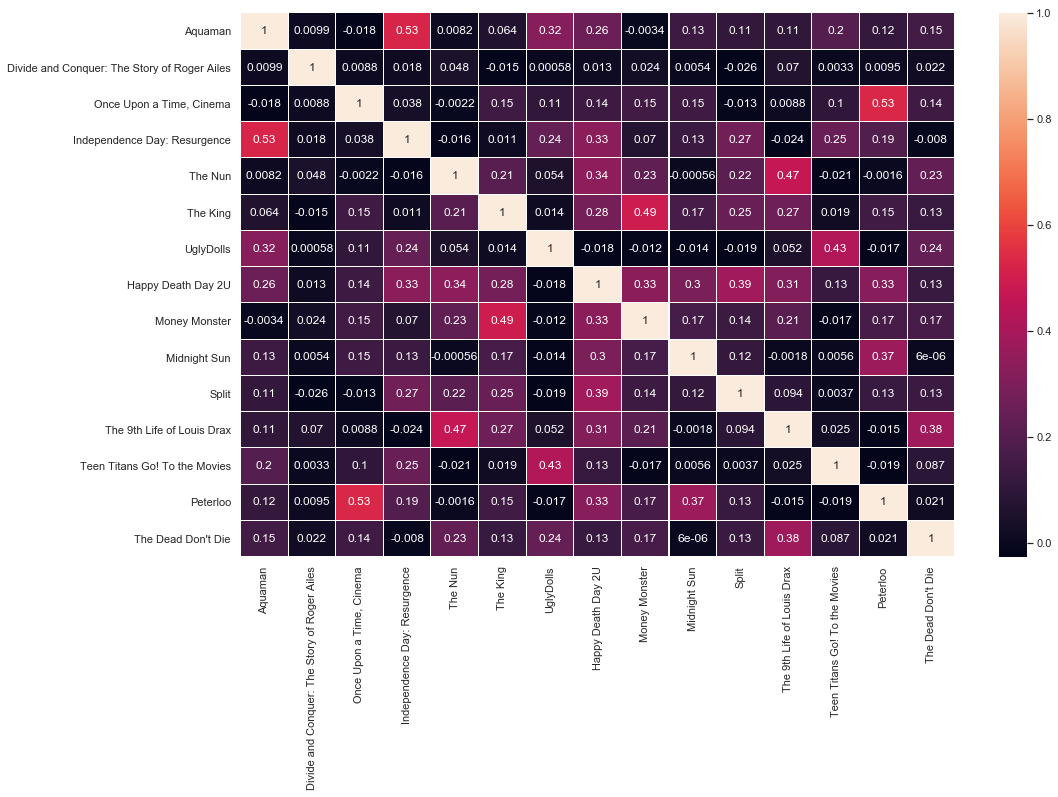

In [45]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.set(font_scale = 1)
x = random.sample(range(0, len(cosine_SVD_matrix) + 1), 15)
sns.heatmap(cosine_SVD_matrix.iloc[x,x], linewidths=.1, annot=True)